In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf

#import AAPL csv, csv data is different from yahoo finance
ticker = "AAPL"
start  = "2017-01-01"
end    = "2025-01-01"
csv_AAPL = yf.download(ticker, start=start, end=end).reset_index()
#since date type is just a object convert it to a datetime object
csv_AAPL['Date'] = pd.to_datetime(csv_AAPL['Date'])

#declare the features
features = ['Close','High','Low','Open','Volume']

#declare the type of scalar you're using
scaler = StandardScaler()
csv_AAPL[features] = scaler.fit_transform(csv_AAPL[features])

# drops Date (or any other non‑numeric columns) if you haven’t already
df_model = csv_AAPL.drop(columns=['Date'])


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\diana\AppData\Local\Temp\ipykernel_14012\2302883446.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_model = csv_AAPL.drop(columns=['Date'])


C:\Users\diana\AppData\Local\Temp\ipykernel_14012\2738890937.py:31: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_fe.drop(columns=['Date','Close','Close_next'])


Iteration 1, loss = 0.18895163
Iteration 2, loss = 0.01244559
Iteration 3, loss = 0.00418302
Iteration 4, loss = 0.00214848
Iteration 5, loss = 0.00161928
Iteration 6, loss = 0.00129076
Iteration 7, loss = 0.00108695
Iteration 8, loss = 0.00096421
Iteration 9, loss = 0.00093124
Iteration 10, loss = 0.00097105
Iteration 11, loss = 0.00104805
Iteration 12, loss = 0.00111443
Iteration 13, loss = 0.00091153
Iteration 14, loss = 0.00164445
Iteration 15, loss = 0.00102122
Iteration 16, loss = 0.00093876
Iteration 17, loss = 0.00111619
Iteration 18, loss = 0.00094051
Iteration 19, loss = 0.00116993
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test MSE: 0.0031
Test R²:  0.9788


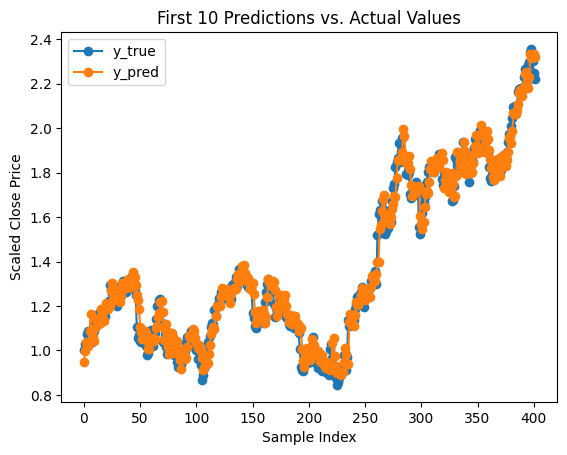

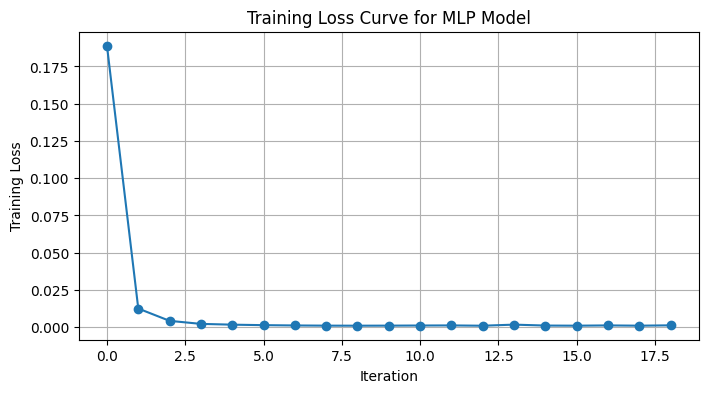

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


#Start from your cleaned & scaled df_model (must include 'Date' & 'Close')
df_fe = csv_AAPL.copy()

#Add lag and rolling‑window features (all shifted by 1 day)
df_fe['Close_lag1']     = df_fe['Close'].shift(1)
df_fe['MA_5']           = df_fe['Close'].rolling(window=5).mean().shift(1)
df_fe['Volatility_5']   = df_fe['Close'].rolling(window=5).std().shift(1)

#Encode weekday cyclically
df_fe['Weekday']        = df_fe['Date'].dt.weekday
df_fe['Weekday_sin']    = np.sin(2 * np.pi * df_fe['Weekday'] / 7)
df_fe['Weekday_cos']    = np.cos(2 * np.pi * df_fe['Weekday'] / 7)

#Drop rows with NaNs (first few days lack history)
df_fe.dropna(inplace=True)

#Create the next-day target
df_fe['Close_next'] = df_fe['Close'].shift(-1)

#Drop the final row (no next-day target)
df_fe = df_fe.iloc[:-1]

X = df_fe.drop(columns=['Date','Close','Close_next'])
y = df_fe['Close_next'].to_numpy().ravel()


#train/test split (80/20 chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

#instantiate and fit your MLP
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128,128,128), #the more data there is the more neurons needed, due to our features
    alpha=1e-4,
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=200,
    random_state=42,
    verbose=True
)
mlp_model.fit(X_train, y_train)

# 8) Evaluate
y_pred = mlp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}")

y_true_10 = y_test   # already 1-D
y_pred_10 = y_pred

df_plot = pd.DataFrame({'y_true': y_true_10, 'y_pred': y_pred_10})
df_plot.plot(marker='o')
plt.title("First 10 Predictions vs. Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Close Price")
plt.show()

#plot training loss trajectory
plt.figure(figsize=(8, 4))
plt.plot(mlp_model.loss_curve_, marker='o')
plt.title("Training Loss Curve for MLP Model")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

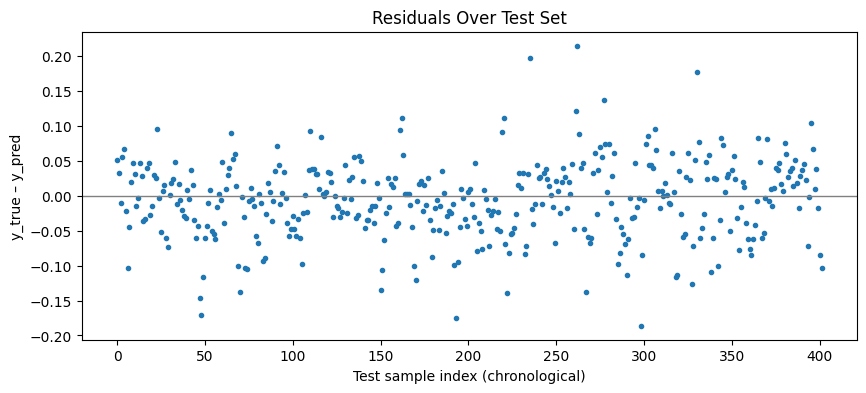

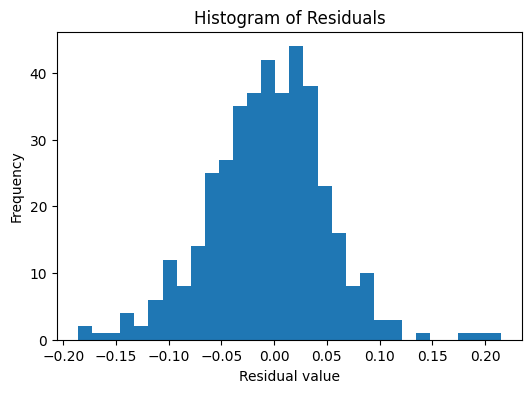

In [3]:
import matplotlib.pyplot as plt

#calculate residuals
y_pred = mlp_model.predict(X_test)
residuals = y_test - y_pred

#plot residuals over time (chronologically)
plt.figure(figsize=(10,4))
plt.plot(residuals, marker='.', linestyle='none')
plt.axhline(0, color='gray', linewidth=1)
plt.title("Residuals Over Test Set")
plt.xlabel("Test sample index (chronological)")
plt.ylabel("y_true – y_pred")
plt.show()

#plot residual histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.show()


In [4]:
#testing model time
import time
start = time.time()
mlp_model.fit(X_train, y_train)
print("Train time:", time.time() - start, "seconds")

# Testing time
start = time.time()
_ = mlp_model.predict(X_test)
print("Test time:", time.time() - start, "seconds")


Iteration 1, loss = 0.18895163
Iteration 2, loss = 0.01244559
Iteration 3, loss = 0.00418302
Iteration 4, loss = 0.00214848
Iteration 5, loss = 0.00161928
Iteration 6, loss = 0.00129076
Iteration 7, loss = 0.00108695
Iteration 8, loss = 0.00096421
Iteration 9, loss = 0.00093124
Iteration 10, loss = 0.00097105
Iteration 11, loss = 0.00104805
Iteration 12, loss = 0.00111443
Iteration 13, loss = 0.00091153
Iteration 14, loss = 0.00164445
Iteration 15, loss = 0.00102122
Iteration 16, loss = 0.00093876
Iteration 17, loss = 0.00111619
Iteration 18, loss = 0.00094051
Iteration 19, loss = 0.00116993
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Train time: 0.3751688003540039 seconds
Test time: 0.0015065670013427734 seconds


In [5]:
#to find mae
from sklearn.metrics import mean_absolute_error

# 1) Compute MAE in scaled units
mae_scaled = mean_absolute_error(y_test, y_pred)
print(f"Test MAE (scaled): {mae_scaled:.4f}")

# 2) Unscale back to dollars
close_idx  = features.index('Close')
close_std  = scaler.scale_[close_idx]
mae_usd    = mae_scaled * close_std
print(f"Test MAE (≈USD): ${mae_usd:.2f}")



Test MAE (scaled): 0.0428
Test MAE (≈USD): $2.68


In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Compute RMSE in scaled units
rmse_scaled = mean_squared_error(y_test, y_pred)
print(f"Test RMSE (scaled): {rmse_scaled:.4f}")

#Convert back to USD
close_idx = ['Close','High','Low','Open','Volume'].index('Close')
close_std = scaler.scale_[close_idx]

rmse_usd = rmse_scaled * close_std
print(f"Test RMSE (≈USD): ${rmse_usd:.2f}")


Test RMSE (scaled): 0.0031
Test RMSE (≈USD): $0.19


In [7]:
#testing time
# Training time
import time
start = time.time()
mlp_model.fit(X_train, y_train)
print("Train time:", time.time() - start, "seconds")

# Testing time
start = time.time()
_ = mlp_model.predict(X_test)
print("Test time:", time.time() - start, "seconds")


Iteration 1, loss = 0.18895163
Iteration 2, loss = 0.01244559
Iteration 3, loss = 0.00418302
Iteration 4, loss = 0.00214848
Iteration 5, loss = 0.00161928
Iteration 6, loss = 0.00129076
Iteration 7, loss = 0.00108695
Iteration 8, loss = 0.00096421
Iteration 9, loss = 0.00093124
Iteration 10, loss = 0.00097105
Iteration 11, loss = 0.00104805
Iteration 12, loss = 0.00111443
Iteration 13, loss = 0.00091153
Iteration 14, loss = 0.00164445
Iteration 15, loss = 0.00102122
Iteration 16, loss = 0.00093876
Iteration 17, loss = 0.00111619
Iteration 18, loss = 0.00094051
Iteration 19, loss = 0.00116993
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Train time: 0.289766788482666 seconds
Test time: 0.0021240711212158203 seconds


In [8]:
#abalation studys
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
#this test only mse
# Time-series-aware split
tscv = TimeSeriesSplit(n_splits=5)

# Define full search space
param_grid = {
    'hidden_layer_sizes': [
        (64,),              # shallow
        (128,),             # medium
        (128, 64),          # 2 layers
        (128, 128),         # 2 deeper
        (128, 128, 64),     # your current
        (128,128,128),
        (256, 128, 64)      # even deeper
    ],
    'learning_rate_init': [0.01,1e-2, 5e-3, 1e-3, 5e-4],
    'alpha': [0, 1e-5, 1e-4, 1e-3]
}

# Wrap the regressor in GridSearchCV
grid = GridSearchCV(
    estimator=MLPRegressor(
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1  # parallelize search if possible
)

# Fit the grid search
grid.fit(X_train, y_train)

# Output best model info
print("✅ Best Parameters:", grid.best_params_)
print("📉 Best CV MSE:", -grid.best_score_)

# Optional: Save best model
# import joblib
# joblib.dump(grid.best_estimator_, 'best_mlp_model.pkl')

import numpy as np

# After your grid search has completed:
results = grid.cv_results_
mean_scores = results['mean_test_score']  # neg-MSE scores
params_list = results['params']

# Sort indices by best (highest) mean_test_score (least negative MSE)
sorted_indices = np.argsort(mean_scores)[::-1]

print("Top 5 parameter sets by CV performance:")
for rank, idx in enumerate(sorted_indices[:5], start=1):
    print(f"Rank  {rank}:")
    print(f"  Params: {params_list[idx]}")
    print(f"  CV MSE: {-mean_scores[idx]:.6f}")





Fitting 5 folds for each of 140 candidates, totalling 700 fits
✅ Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.005}
📉 Best CV MSE: 0.006002686451714508
Top 5 parameter sets by CV performance:
Rank  1:
  Params: {'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.005}
  CV MSE: 0.006003
Rank  2:
  Params: {'alpha': 0.001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.005}
  CV MSE: 0.006549
Rank  3:
  Params: {'alpha': 1e-05, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.005}
  CV MSE: 0.006973
Rank  4:
  Params: {'alpha': 1e-05, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}
  CV MSE: 0.007202
Rank  5:
  Params: {'alpha': 1e-05, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}
  CV MSE: 0.007202
